# Imports

In [1]:
import matplotlib
from google.colab import runtime

# Por defecto tiene matplotlib: 3.2.2
print('matplotlib: {}'.format(matplotlib.__version__))

if matplotlib.__version__ == '3.2.2':
    # Se necesita la versión 3.5.1 que soporta float16 para pintar kanji
    !pip install -U matplotlib

    print('Stopping RUNTIME! Please run again.')
    quit()
    # https://twitter.com/GoogleColab/status/1569389018311426051

matplotlib: 3.7.0


In [2]:
# track time of each cell
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
time: 356 µs (started: 2023-02-21 17:32:09 +00:00)


In [3]:
from pprint import pprint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow, subplots, show
import PIL as pil
import skimage.transform
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    classification_report,
    confusion_matrix
)
from tensorflow import keras
from keras.layers import (
    Conv2D, MaxPool2D, Flatten, Dense, Dropout, Input, Concatenate
)
from keras.models import Model
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from google.colab import drive

time: 3.36 s (started: 2023-02-21 17:32:09 +00:00)


In [4]:
CHANNEL = 1
DATA_REPR = 'float32' # Antes era 'uint8'
NUM_CLASSES = 2965
ETL_DATASET = 'etl_9G'
DNN_NAME = 'VGG19'
FC_LAYER = 4096

USE_DATA_AUG = 'sin_DA' # o también con_DA
TYPE_IMG = 'inverted'

TFM_PATH = '/content/gdrive/MyDrive/Master_IA/TFM/'
ROOT_PATH = TFM_PATH + 'datasets/'+ ETL_DATASET +'/uint32/imgs_{}/splits/'+ TYPE_IMG +'_otsu/'

print(ROOT_PATH)
print('versión Keras:', keras.__version__)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_{}/splits/inverted_otsu/
versión Keras: 2.11.0
time: 1.6 ms (started: 2023-02-21 17:32:12 +00:00)


In [5]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive
time: 29.4 s (started: 2023-02-21 17:32:12 +00:00)


# Funciones

In [6]:
def load_images_for_training(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for training and validation images
    '''
    if TYPE_IMG == 'regular':
        train_name_img = 'train_imgs_9G.npz'
        train_name_labels = 'train_labels_9G.npz'
        val_name_img = 'val_imgs_9G.npz'
        val_name_labels = 'val_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        train_name_img = 'train_inv_imgs_9G.npz'
        train_name_labels = 'train_inv_labels_9G.npz'
        val_name_img = 'val_inv_imgs_9G.npz'
        val_name_labels = 'val_inv_labels_9G.npz'

    train_images = np.load(PATH+train_name_img)['arr_0']
    train_labels = np.load(PATH+train_name_labels)['arr_0'].astype(DATA_REPR)

    val_images = np.load(PATH+val_name_img)['arr_0']
    val_labels = np.load(PATH+val_name_labels)['arr_0'].astype(DATA_REPR)

    return train_images, train_labels, val_images, val_labels


def load_test_images(DATA_REPR, PATH, TYPE_IMG):
    '''
    Load images for training and validation with their labels

    Args:

    - DATA_REPR: Representation of numpy data. Ex: uint8, float32
    - ROOT_PATH: Path in Google Drive where imgs and labels are stored

    Output:
    - np arrays for testing images
    '''

    if TYPE_IMG == 'regular':
        test_name_img = 'test_imgs_9G.npz'
        test_name_labels = 'test_labels_9G.npz'
    elif TYPE_IMG == 'inverted':
        test_name_img = 'test_inv_imgs_9G.npz'
        test_name_labels = 'test_inv_labels_9G.npz'

    test_images = np.load(PATH+test_name_img)['arr_0']
    test_labels = np.load(PATH+test_name_labels)['arr_0'].astype(DATA_REPR)

    return test_images, test_labels


def avg_wts(weights):
    '''
    Function that calculates average of weights along the channel axis
    '''

    # Find mean along the channel axis (second to last axis)
    average_weights = np.mean(
        weights, axis=-2).reshape(weights[:,:,-1:,:].shape
    )  
    return(average_weights)


def configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL):
    vgg_model = keras.applications.VGG19(
        include_top=False, 
        weights='imagenet'
    )

    # Get the dictionary of config for VGG19
    vgg_config = vgg_model.get_config()


    vgg_config["layers"][0]["config"]["batch_input_shape"] = (
        None, HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL
    )

    # Create new model with the updated configuration
    vgg_updated = Model.from_config(vgg_config)

    # Get the configuration for the updated model and extract layer names. 
    # We will use these names to copy over weights from the original model. 
    vgg_updated_config = vgg_updated.get_config()
    vgg_updated_layer_names = [vgg_updated_config['layers'][x]['name'] for x in range(len(vgg_updated_config['layers']))]

    # Name of the first convolutional layer.
    # Remember that this is the only layer with new additional weights. 
    # All other layers will have same weights as the original model. 
    first_conv_name = vgg_updated_layer_names[1]

    # Update weights for all layers. 
    # And for the first conv layer replace weights with average of all 3 channels. 
    for layer in vgg_model.layers:
        if layer.name in vgg_updated_layer_names:
         

            if layer.get_weights() != []:
                target_layer = vgg_updated.get_layer(layer.name)
        
                if layer.name in first_conv_name:    #For the first convolutionl layer
                    weights = layer.get_weights()[0]
                    biases  = layer.get_weights()[1]
              
                    weights_single_channel = avg_wts(weights)
                                                        
                    target_layer.set_weights([weights_single_channel, biases])  #Now set weights for the first conv. layer
                    target_layer.trainable = False   #You can make this trainable if you want. 
        
                else:
                    target_layer.set_weights(layer.get_weights())   #Set weights to all other layers. 
                    target_layer.trainable = False  #You can make this trainable if you want. 

    return vgg_updated

def create_custom_model(NUM_CLASSES, vgg_updated):

    # KerasTensor(type_spec=TensorSpec(shape=(None, 2, 2, 512), dtype=tf.float32, name=None), name='block5_pool/MaxPool:0', description="created by layer 'block5_pool'")
    last_layer = vgg_updated.layers[-1].output

    x = Flatten(name='flatten', input_shape=vgg_updated.output_shape[1:])(last_layer)
    x = Dense(FC_LAYER, activation='relu', name='fc1')(x)
    x = Dense(FC_LAYER, activation='relu', name='fc2')(x)
    out = Dense(NUM_CLASSES, activation='softmax', name='predictions')(x) # activation relu??
    custom_model = Model(vgg_updated.inputs, out)

    for layer in custom_model.layers[:-3]: # Hasta aquí llega hasta flatten
        layer.trainable = False

    return custom_model


def train_model(custom_model, train_images, train_labels, val_images, val_labels):

    callback = EarlyStopping(
        monitor='val_sparse_categorical_accuracy',
        patience=5,
        verbose=1
    )

    custom_model.compile(
        loss="sparse_categorical_crossentropy",
        optimizer=Adam(learning_rate=0.0001),
        metrics=["sparse_categorical_accuracy"]
    )

    history = custom_model.fit(
        train_images,
        train_labels,
        validation_data=(val_images, val_labels),
        epochs= 50, # en 2022 usé 20 epochs
        callbacks = [callback],
        # verbose = 1,
        # batch_size=32
    )

    print('--- Iterations ended ---')
    print()
    print()

    return history


def show_metrics(custom_model, test_images, test_labels):
    test_loss, test_accuracy = custom_model.evaluate(test_images, test_labels)
    y_pred = np.argmax(custom_model.predict(test_images), axis=1)

    print("*********************************************************************************************************************************")
    print()
    print("- Test Accuracy:", test_accuracy)
    print("- Test Loss:", test_loss)
    print("- time: ")
    print("- F1 score:", f1_score(test_labels, y_pred, average='weighted'))
    print("- Precision score:", precision_score(test_labels, y_pred, average='weighted'))
    print("- Recall: ", recall_score(test_labels, y_pred, average='weighted'))
    print("- Epoch: ")
    print("*********************************************************************************************************************************")


def plot_loss(history):
    pd.DataFrame(history.history).plot(figsize=(7,5))
    plt.grid(True)
    plt.gca().set_ylim(0,2) # usualmente 0,5
    plt.show()


def show_history(history):
    #-----------------------------------------------------------
    # Recuperar una lista de resultados de la lista de datos de los conjuntos de entrenamiento y pruebas para cada epoch de entrenamiento
    #-----------------------------------------------------------

    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    #------------------------------------------------
    # Imprimir la precisión del entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Precisión de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.figure()

    #------------------------------------------------
    # Imprimir la perdida de entrenamiento y validación por epoch
    #------------------------------------------------
    plt.plot(epochs, loss, 'bo', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Perdida de entrenamiento y validación')
    plt.legend()
    plt.grid()
    plt.show()


def save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER):
    '''Guardar el modelo en disco duro
    
    Args:
        -SIZE = 64, 96, 112 ó 127
        -TFM_PATH = Ruta en drive a la carpeta del TFM
        -custom_model = Modelo de Deep Learning
        -TYPE_IMG = regular o inverted
        -USE_DATA_AUG = sin_DA o con_DA
        -DNN_NAME = Deep Neural Network Architecture's name
    '''
    MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' \
                + TYPE_IMG + f'_FC_{FC_LAYER}__OTSU.h5'

    WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME

    # Por default lo guarda es en el mismo Google Colab's notebook
    custom_model.save(WEIGHTS_PATH)

    print('------ Model Saved -------')


time: 10.3 ms (started: 2023-02-21 17:33:43 +00:00)


# Imgs 64x64

- Test Accuracy: 0.7434064149856567
- Test Loss: 1.458743929862976
- time: 39min 52s
- F1 score: 0.7449759365615989
- Precision score: 0.7716874140956993
- Recall:  0.743406408094435
- Epoch: 23/50



## Cargar la imágenes

In [9]:
SIZE = 64  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_64/splits/inverted_otsu/
time: 1.14 ms (started: 2023-02-21 17:34:11 +00:00)


In [10]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 8.75 s (started: 2023-02-21 17:34:12 +00:00)


In [11]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()
print()

- train images: (444750, 64, 64, 1) and labels: (444750,)

- val images: (88950, 64, 64, 1) and labels: (88950,)


time: 1.24 ms (started: 2023-02-21 17:34:21 +00:00)


## Preparar el modelo

In [12]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

80134624/80134624 [==============================] - 0s 0us/step
time: 4.81 s (started: 2023-02-21 17:34:21 +00:00)


In [13]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 45.7 ms (started: 2023-02-21 17:34:26 +00:00)


In [14]:
print(custom_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

## Entrenar modelo

In [15]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 113s 8ms/step - loss: 4.4049 - sparse_categorical_accuracy: 0.1816 - val_loss: 2.9453 - val_sparse_categorical_accuracy: 0.3528
Epoch 2/50
13899/13899 [==============================] - 103s 7ms/step - loss: 2.3468 - sparse_categorical_accuracy: 0.4640 - val_loss: 2.0228 - val_sparse_categorical_accuracy: 0.5300
Epoch 3/50
13899/13899 [==============================] - 103s 7ms/step - loss: 1.7845 - sparse_categorical_accuracy: 0.5772 - val_loss: 1.7770 - val_sparse_categorical_accuracy: 0.5803
Epoch 4/50
13899/13899 [==============================] - 103s 7ms/step - loss: 1.4841 - sparse_categorical_accuracy: 0.6420 - val_loss: 1.5359 - val_sparse_categorical_accuracy: 0.6338
Epoch 5/50
13899/13899 [==============================] - 103s 7ms/step - loss: 1.2820 - sparse_categorical_accuracy: 0.6867 - val_loss: 1.4225 - val_sparse_categorical_accuracy: 0.6608
Epoch 6/50
13899/13899 [==============================] - 103s 7ms/ste

In [16]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.09 s (started: 2023-02-21 18:14:18 +00:00)


In [17]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 7s 4ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.7434064149856567
- Test Loss: 1.458743929862976
- time: 
- F1 score: 0.7449759365615989
- Precision score: 0.7716874140956993
- Recall:  0.743406408094435
- Epoch: 
*********************************************************************************************************************************
time: 20.6 s (started: 2023-02-21 18:14:19 +00:00)


## Graficando

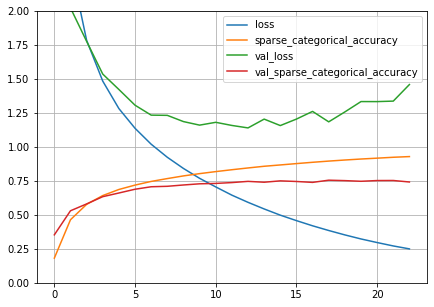

time: 297 ms (started: 2023-02-21 18:14:40 +00:00)


In [18]:
plot_loss(history)

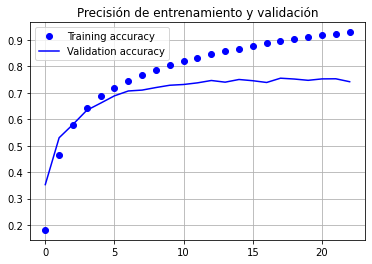

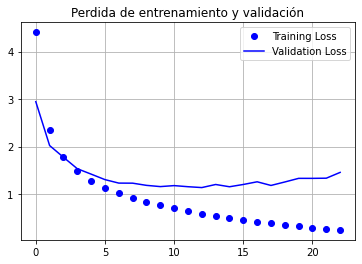

time: 369 ms (started: 2023-02-21 18:14:40 +00:00)


In [19]:
show_history(history)

In [20]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 1.72 s (started: 2023-02-21 18:14:41 +00:00)


# Imgs 96x96

- Test Accuracy: 0.8423103094100952
- Test Loss: 1.0092430114746094
- time: 47min 41s
- F1 score: 0.8438848752669528
- Precision score: 0.8602261677947017
- Recall:  0.842310286677909
- Epoch: 22/50


## Cargar las imágenes

In [21]:
SIZE = 96  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_96/splits/inverted_otsu/
time: 1.08 ms (started: 2023-02-21 18:14:43 +00:00)


In [22]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 14.6 s (started: 2023-02-21 18:14:43 +00:00)


In [23]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 96, 96, 1) and labels: (444750,)

- val images: (88950, 96, 96, 1) and labels: (88950,)

time: 1.18 ms (started: 2023-02-21 18:14:58 +00:00)


## Preparar el modelo

In [24]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 677 ms (started: 2023-02-21 18:14:58 +00:00)


In [25]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 37.3 ms (started: 2023-02-21 18:14:58 +00:00)


In [26]:
print(custom_model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 1)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        640       
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0   

## Entrenar modelo

In [27]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 132s 9ms/step - loss: 3.3863 - sparse_categorical_accuracy: 0.3289 - val_loss: 1.7618 - val_sparse_categorical_accuracy: 0.5719
Epoch 2/50
13899/13899 [==============================] - 130s 9ms/step - loss: 1.3854 - sparse_categorical_accuracy: 0.6559 - val_loss: 1.2480 - val_sparse_categorical_accuracy: 0.6878
Epoch 3/50
13899/13899 [==============================] - 130s 9ms/step - loss: 0.9905 - sparse_categorical_accuracy: 0.7477 - val_loss: 1.0061 - val_sparse_categorical_accuracy: 0.7465
Epoch 4/50
13899/13899 [==============================] - 130s 9ms/step - loss: 0.7876 - sparse_categorical_accuracy: 0.7957 - val_loss: 0.8391 - val_sparse_categorical_accuracy: 0.7881
Epoch 5/50
13899/13899 [==============================] - 130s 9ms/step - loss: 0.6554 - sparse_categorical_accuracy: 0.8286 - val_loss: 0.8144 - val_sparse_categorical_accuracy: 0.7987
Epoch 6/50
13899/13899 [==============================] - 130s 9ms/ste

In [28]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 1.87 s (started: 2023-02-21 19:02:40 +00:00)


In [29]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 9s 5ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8423103094100952
- Test Loss: 1.0092430114746094
- time: 
- F1 score: 0.8438848752669528
- Precision score: 0.8602261677947017
- Recall:  0.842310286677909
- Epoch: 
*********************************************************************************************************************************
time: 24.8 s (started: 2023-02-21 19:02:42 +00:00)


## Graficando

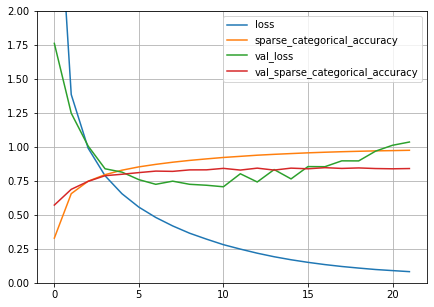

time: 185 ms (started: 2023-02-21 19:03:07 +00:00)


In [30]:
plot_loss(history)

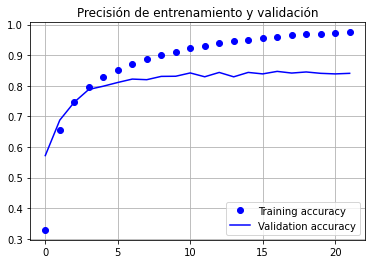

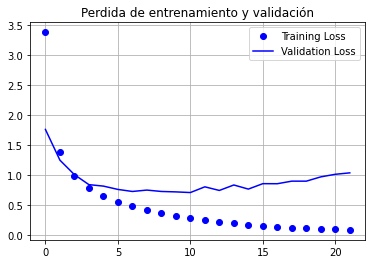

time: 400 ms (started: 2023-02-21 19:03:07 +00:00)


In [31]:
show_history(history)

In [32]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 1.43 s (started: 2023-02-21 19:03:08 +00:00)


# Imgs 112x112

- Test Accuracy: 0.860303521156311
- Test Loss: 0.758958637714386
- time: 37min 41s
- F1 score: 0.8616124950280306
- Precision score: 0.8767787380085731
- Recall:  0.8603035413153457
- Epoch: 16/50


## Cargar imágenes

In [33]:
SIZE = 112  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_112/splits/inverted_otsu/
time: 688 µs (started: 2023-02-21 19:03:09 +00:00)


In [34]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 19.6 s (started: 2023-02-21 19:03:09 +00:00)


In [35]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 112, 112, 1) and labels: (444750,)

- val images: (88950, 112, 112, 1) and labels: (88950,)

time: 1.3 ms (started: 2023-02-21 19:03:29 +00:00)


## Preparar el modelo

In [36]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 694 ms (started: 2023-02-21 19:03:29 +00:00)


In [37]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 39.5 ms (started: 2023-02-21 19:03:30 +00:00)


In [38]:
print(custom_model.summary())

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 112, 112, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 112, 112, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 112, 112, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 56, 56, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 56, 56, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 56, 56, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 28, 28, 128)       0   

## Entrenar modelo


In [39]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 143s 10ms/step - loss: 2.9415 - sparse_categorical_accuracy: 0.4054 - val_loss: 1.4513 - val_sparse_categorical_accuracy: 0.6384
Epoch 2/50
13899/13899 [==============================] - 141s 10ms/step - loss: 1.0988 - sparse_categorical_accuracy: 0.7209 - val_loss: 0.9711 - val_sparse_categorical_accuracy: 0.7524
Epoch 3/50
13899/13899 [==============================] - 141s 10ms/step - loss: 0.7761 - sparse_categorical_accuracy: 0.7984 - val_loss: 0.8374 - val_sparse_categorical_accuracy: 0.7882
Epoch 4/50
13899/13899 [==============================] - 141s 10ms/step - loss: 0.6114 - sparse_categorical_accuracy: 0.8399 - val_loss: 0.7389 - val_sparse_categorical_accuracy: 0.8108
Epoch 5/50
13899/13899 [==============================] - 141s 10ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.8672 - val_loss: 0.6516 - val_sparse_categorical_accuracy: 0.8352
Epoch 6/50
13899/13899 [==============================] - 141s 10

## Graficando

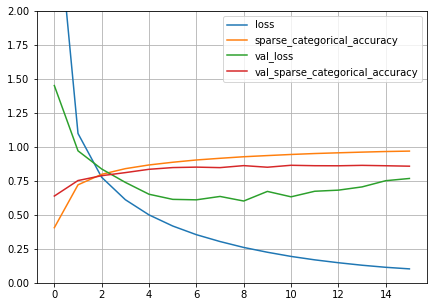

time: 206 ms (started: 2023-02-21 19:41:11 +00:00)


In [40]:
plot_loss(history)

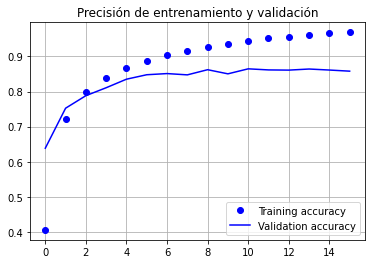

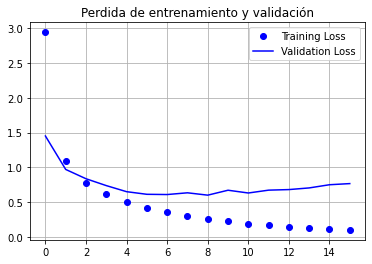

time: 387 ms (started: 2023-02-21 19:41:11 +00:00)


In [41]:
show_history(history)

In [42]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 1.42 s (started: 2023-02-21 19:41:12 +00:00)


## Métricas

In [43]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.54 s (started: 2023-02-21 19:41:13 +00:00)


In [44]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 11s 6ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.860303521156311
- Test Loss: 0.758958637714386
- time: 
- F1 score: 0.8616124950280306
- Precision score: 0.8767787380085731
- Recall:  0.8603035413153457
- Epoch: 
*********************************************************************************************************************************
time: 27 s (started: 2023-02-21 19:41:16 +00:00)


In [45]:
#quit()

time: 395 µs (started: 2023-02-21 19:41:43 +00:00)


# Imgs 127x127

- Test Accuracy: 0.8681619167327881
- Test Loss: 0.9711983799934387
- time: 1h 2min 57s
- F1 score: 0.8696715054694817
- Precision score: 0.8844471502335081
- Recall:  0.8681618887015177
- Epoch: 22/50



## Cargar imágenes

In [46]:
SIZE = 127  # integer number. Ex: 64, 96, 112 or 127
WIDTH_SHAPE = SIZE
HEIGHT_SHAPE = SIZE
PATH = ROOT_PATH.format(SIZE)

print(PATH)

/content/gdrive/MyDrive/Master_IA/TFM/datasets/etl_9G/uint32/imgs_127/splits/inverted_otsu/
time: 697 µs (started: 2023-02-21 19:41:43 +00:00)


In [47]:
train_images, train_labels, val_images, val_labels = load_images_for_training(DATA_REPR, PATH, TYPE_IMG)

time: 24 s (started: 2023-02-21 19:41:43 +00:00)


In [48]:
print('- train images:', train_images.shape, 'and labels:', train_labels.shape)
print()
print('- val images:', val_images.shape, 'and labels:', val_labels.shape)
print()

- train images: (444750, 127, 127, 1) and labels: (444750,)

- val images: (88950, 127, 127, 1) and labels: (88950,)

time: 1.39 ms (started: 2023-02-21 19:42:07 +00:00)


## Preparar el modelo

In [49]:
vgg_updated = configure_weights_model(HEIGHT_SHAPE , WIDTH_SHAPE, CHANNEL)

time: 700 ms (started: 2023-02-21 19:42:07 +00:00)


In [50]:
custom_model = create_custom_model(NUM_CLASSES, vgg_updated)

time: 32.7 ms (started: 2023-02-21 19:42:07 +00:00)


In [51]:
print(custom_model.summary())

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 127, 127, 1)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 127, 127, 64)      640       
                                                                 
 block1_conv2 (Conv2D)       (None, 127, 127, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 63, 63, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 63, 63, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 63, 63, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 31, 31, 128)       0   

## Entrenar modelo

In [52]:
history = train_model(custom_model, train_images, train_labels, val_images, val_labels)

Epoch 1/50
13899/13899 [==============================] - 173s 12ms/step - loss: 2.6191 - sparse_categorical_accuracy: 0.4629 - val_loss: 1.2265 - val_sparse_categorical_accuracy: 0.6894
Epoch 2/50
13899/13899 [==============================] - 172s 12ms/step - loss: 0.9117 - sparse_categorical_accuracy: 0.7647 - val_loss: 0.8065 - val_sparse_categorical_accuracy: 0.7922
Epoch 3/50
13899/13899 [==============================] - 171s 12ms/step - loss: 0.6421 - sparse_categorical_accuracy: 0.8309 - val_loss: 0.6877 - val_sparse_categorical_accuracy: 0.8237
Epoch 4/50
13899/13899 [==============================] - 171s 12ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.8664 - val_loss: 0.6011 - val_sparse_categorical_accuracy: 0.8455
Epoch 5/50
13899/13899 [==============================] - 171s 12ms/step - loss: 0.4071 - sparse_categorical_accuracy: 0.8902 - val_loss: 0.6120 - val_sparse_categorical_accuracy: 0.8489
Epoch 6/50
13899/13899 [==============================] - 171s 12

## Graficando

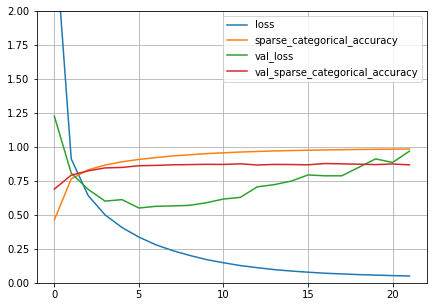

time: 199 ms (started: 2023-02-21 20:45:05 +00:00)


In [53]:
plot_loss(history)

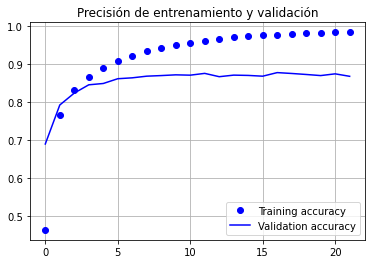

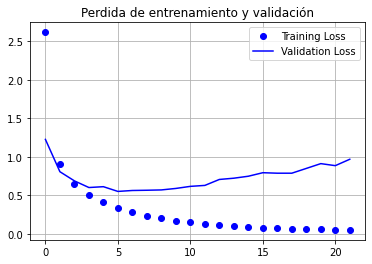

time: 362 ms (started: 2023-02-21 20:45:06 +00:00)


In [54]:
show_history(history)

In [55]:
save_model(SIZE, TFM_PATH, custom_model, TYPE_IMG, USE_DATA_AUG, DNN_NAME, FC_LAYER)

------ Model Saved -------
time: 1.43 s (started: 2023-02-21 20:45:06 +00:00)


## Métricas


In [56]:
test_images, test_labels = load_test_images(DATA_REPR, PATH, TYPE_IMG)

time: 2.93 s (started: 2023-02-21 20:45:07 +00:00)


In [57]:
# Cargar modelo

'''MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'
WEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/' \
                + DNN_NAME + f'/weights_{DNN_NAME.lower()}/' \
                + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME


print(WEIGHTS_PATH)

custom_model = keras.models.load_model(WEIGHTS_PATH)'''

"MODEL_NAME = f'model_{DNN_NAME.lower()}_etl9_imgs{SIZE}_' + TYPE_IMG +'.h5'\nWEIGHTS_PATH = TFM_PATH + 'notebooks/arqs_2023/'                 + DNN_NAME + f'/weights_{DNN_NAME.lower()}/'                 + USE_DATA_AUG +'/'+ TYPE_IMG +'/' + MODEL_NAME\n\n\nprint(WEIGHTS_PATH)\n\ncustom_model = keras.models.load_model(WEIGHTS_PATH)"

time: 2.25 ms (started: 2023-02-21 20:45:10 +00:00)


In [58]:
show_metrics(custom_model, test_images, test_labels)

1854/1854 [==============================] - 14s 7ms/step
*********************************************************************************************************************************

- Test Accuracy: 0.8681619167327881
- Test Loss: 0.9711983799934387
- time: 
- F1 score: 0.8696715054694817
- Precision score: 0.8844471502335081
- Recall:  0.8681618887015177
- Epoch: 
*********************************************************************************************************************************
time: 33.9 s (started: 2023-02-21 20:45:10 +00:00)


In [ ]:
runtime.unassign()